#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/3)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://api.semanticscholar.org/CorpusID:216056360).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


## Setup


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

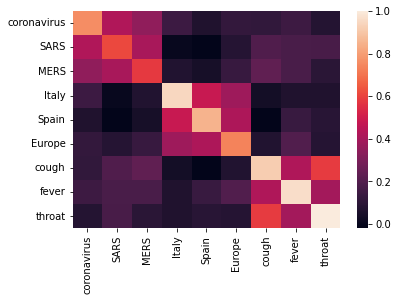

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using Keras.  Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17,302,019


Trainable params: 387


Non-trainable params: 17,301,632


_________________________________________________________________


## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 4:06 - loss: 1.6864 - accuracy: 0.2500

 17/257 [>.............................] - ETA: 0s - loss: 1.4958 - accuracy: 0.2610  

 34/257 [==>...........................] - ETA: 0s - loss: 1.3652 - accuracy: 0.3042

 52/257 [=====>........................] - ETA: 0s - loss: 1.2769 - accuracy: 0.3359

 69/257 [=======>......................] - ETA: 0s - loss: 1.2187 - accuracy: 0.3505

 86/257 [=========>....................] - ETA: 0s - loss: 1.1794 - accuracy: 0.3768

104/257 [===========>..................] - ETA: 0s - loss: 1.1369 - accuracy: 0.4041

122/257 [=============>................] - ETA: 0s - loss: 1.1058 - accuracy: 0.4301

140/257 [===============>..............] - ETA: 0s - loss: 1.0783 - accuracy: 0.4489

157/257 [=================>............] - ETA: 0s - loss: 1.0605 - accuracy: 0.4598

174/257 [===================>..........] - ETA: 0s - loss: 1.0429 - accuracy: 0.4734

192/257 [=====================>........] - ETA: 0s - loss: 1.0273 - accuracy: 0.4847

209/257 [=======================>......] - ETA: 0s - loss: 1.0143 - accuracy: 0.4951

227/257 [=========================>....] - ETA: 0s - loss: 0.9974 - accuracy: 0.5087

245/257 [===========================>..] - ETA: 0s - loss: 0.9840 - accuracy: 0.5188

257/257 [==============================] - 2s 5ms/step - loss: 0.9773 - accuracy: 0.5233 - val_loss: 0.8163 - val_accuracy: 0.6507


Epoch 2/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.7030 - accuracy: 0.7188

 18/257 [=>............................] - ETA: 0s - loss: 0.7898 - accuracy: 0.6736  

 35/257 [===>..........................] - ETA: 0s - loss: 0.7824 - accuracy: 0.6866

 52/257 [=====>........................] - ETA: 0s - loss: 0.7740 - accuracy: 0.6827

 69/257 [=======>......................] - ETA: 0s - loss: 0.7637 - accuracy: 0.6861

 86/257 [=========>....................] - ETA: 0s - loss: 0.7607 - accuracy: 0.6846

103/257 [===========>..................] - ETA: 0s - loss: 0.7568 - accuracy: 0.6842

120/257 [=============>................] - ETA: 0s - loss: 0.7476 - accuracy: 0.6917

137/257 [==============>...............] - ETA: 0s - loss: 0.7427 - accuracy: 0.6937

154/257 [================>.............] - ETA: 0s - loss: 0.7382 - accuracy: 0.6956

171/257 [==================>...........] - ETA: 0s - loss: 0.7326 - accuracy: 0.7005

188/257 [====================>.........] - ETA: 0s - loss: 0.7314 - accuracy: 0.7011

205/257 [======================>.......] - ETA: 0s - loss: 0.7290 - accuracy: 0.7024

222/257 [========================>.....] - ETA: 0s - loss: 0.7225 - accuracy: 0.7069

240/257 [===========================>..] - ETA: 0s - loss: 0.7219 - accuracy: 0.7061

257/257 [==============================] - 1s 4ms/step - loss: 0.7192 - accuracy: 0.7071 - val_loss: 0.6928 - val_accuracy: 0.7227


Epoch 3/35


  1/257 [..............................] - ETA: 1:15 - loss: 0.6953 - accuracy: 0.6875

 18/257 [=>............................] - ETA: 0s - loss: 0.6568 - accuracy: 0.7378  

 35/257 [===>..........................] - ETA: 0s - loss: 0.6493 - accuracy: 0.7384

 52/257 [=====>........................] - ETA: 0s - loss: 0.6485 - accuracy: 0.7410

 69/257 [=======>......................] - ETA: 0s - loss: 0.6516 - accuracy: 0.7378

 86/257 [=========>....................] - ETA: 0s - loss: 0.6436 - accuracy: 0.7416

103/257 [===========>..................] - ETA: 0s - loss: 0.6475 - accuracy: 0.7348

121/257 [=============>................] - ETA: 0s - loss: 0.6484 - accuracy: 0.7381

138/257 [===============>..............] - ETA: 0s - loss: 0.6484 - accuracy: 0.7380

156/257 [=================>............] - ETA: 0s - loss: 0.6481 - accuracy: 0.7412

174/257 [===================>..........] - ETA: 0s - loss: 0.6429 - accuracy: 0.7434

191/257 [=====================>........] - ETA: 0s - loss: 0.6396 - accuracy: 0.7467

209/257 [=======================>......] - ETA: 0s - loss: 0.6356 - accuracy: 0.7494

227/257 [=========================>....] - ETA: 0s - loss: 0.6319 - accuracy: 0.7511

245/257 [===========================>..] - ETA: 0s - loss: 0.6343 - accuracy: 0.7500

257/257 [==============================] - 1s 4ms/step - loss: 0.6345 - accuracy: 0.7493 - val_loss: 0.6385 - val_accuracy: 0.7369


Epoch 4/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.6741 - accuracy: 0.7188

 18/257 [=>............................] - ETA: 0s - loss: 0.5805 - accuracy: 0.7830  

 35/257 [===>..........................] - ETA: 0s - loss: 0.5917 - accuracy: 0.7714

 52/257 [=====>........................] - ETA: 0s - loss: 0.5947 - accuracy: 0.7704

 69/257 [=======>......................] - ETA: 0s - loss: 0.5899 - accuracy: 0.7699

 87/257 [=========>....................] - ETA: 0s - loss: 0.5950 - accuracy: 0.7644

105/257 [===========>..................] - ETA: 0s - loss: 0.5952 - accuracy: 0.7628

123/257 [=============>................] - ETA: 0s - loss: 0.5969 - accuracy: 0.7622

141/257 [===============>..............] - ETA: 0s - loss: 0.5941 - accuracy: 0.7655

158/257 [=================>............] - ETA: 0s - loss: 0.5936 - accuracy: 0.7668

176/257 [===================>..........] - ETA: 0s - loss: 0.5952 - accuracy: 0.7662

194/257 [=====================>........] - ETA: 0s - loss: 0.5946 - accuracy: 0.7680

212/257 [=======================>......] - ETA: 0s - loss: 0.5952 - accuracy: 0.7692

230/257 [=========================>....] - ETA: 0s - loss: 0.5948 - accuracy: 0.7693

247/257 [===========================>..] - ETA: 0s - loss: 0.5932 - accuracy: 0.7704

257/257 [==============================] - 1s 4ms/step - loss: 0.5939 - accuracy: 0.7687 - val_loss: 0.6084 - val_accuracy: 0.7511


Epoch 5/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.5073 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.5723 - accuracy: 0.7852  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5674 - accuracy: 0.7812

 48/257 [====>.........................] - ETA: 0s - loss: 0.5663 - accuracy: 0.7754

 65/257 [======>.......................] - ETA: 0s - loss: 0.5686 - accuracy: 0.7793

 82/257 [========>.....................] - ETA: 0s - loss: 0.5769 - accuracy: 0.7767

 99/257 [==========>...................] - ETA: 0s - loss: 0.5738 - accuracy: 0.7797

116/257 [============>.................] - ETA: 0s - loss: 0.5726 - accuracy: 0.7802

132/257 [==============>...............] - ETA: 0s - loss: 0.5660 - accuracy: 0.7841

148/257 [================>.............] - ETA: 0s - loss: 0.5678 - accuracy: 0.7817

164/257 [==================>...........] - ETA: 0s - loss: 0.5670 - accuracy: 0.7807

180/257 [====================>.........] - ETA: 0s - loss: 0.5692 - accuracy: 0.7781

196/257 [=====================>........] - ETA: 0s - loss: 0.5735 - accuracy: 0.7763

212/257 [=======================>......] - ETA: 0s - loss: 0.5717 - accuracy: 0.7776

228/257 [=========================>....] - ETA: 0s - loss: 0.5712 - accuracy: 0.7777

244/257 [===========================>..] - ETA: 0s - loss: 0.5713 - accuracy: 0.7786

257/257 [==============================] - 1s 4ms/step - loss: 0.5709 - accuracy: 0.7781 - val_loss: 0.5918 - val_accuracy: 0.7511


Epoch 6/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.6358 - accuracy: 0.7812

 18/257 [=>............................] - ETA: 0s - loss: 0.5446 - accuracy: 0.7865  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5704 - accuracy: 0.7795

 53/257 [=====>........................] - ETA: 0s - loss: 0.5586 - accuracy: 0.7789

 71/257 [=======>......................] - ETA: 0s - loss: 0.5635 - accuracy: 0.7790

 89/257 [=========>....................] - ETA: 0s - loss: 0.5717 - accuracy: 0.7781

108/257 [===========>..................] - ETA: 0s - loss: 0.5787 - accuracy: 0.7705

126/257 [=============>................] - ETA: 0s - loss: 0.5763 - accuracy: 0.7726

143/257 [===============>..............] - ETA: 0s - loss: 0.5687 - accuracy: 0.7751

160/257 [=================>............] - ETA: 0s - loss: 0.5662 - accuracy: 0.7783

177/257 [===================>..........] - ETA: 0s - loss: 0.5655 - accuracy: 0.7781

194/257 [=====================>........] - ETA: 0s - loss: 0.5633 - accuracy: 0.7787

211/257 [=======================>......] - ETA: 0s - loss: 0.5588 - accuracy: 0.7807

228/257 [=========================>....] - ETA: 0s - loss: 0.5574 - accuracy: 0.7818

245/257 [===========================>..] - ETA: 0s - loss: 0.5573 - accuracy: 0.7821

257/257 [==============================] - 1s 4ms/step - loss: 0.5565 - accuracy: 0.7826 - val_loss: 0.5824 - val_accuracy: 0.7598


Epoch 7/35


  1/257 [..............................] - ETA: 1:13 - loss: 0.4006 - accuracy: 0.8750

 18/257 [=>............................] - ETA: 0s - loss: 0.5456 - accuracy: 0.7951  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5765 - accuracy: 0.7648

 53/257 [=====>........................] - ETA: 0s - loss: 0.5708 - accuracy: 0.7695

 70/257 [=======>......................] - ETA: 0s - loss: 0.5653 - accuracy: 0.7705

 87/257 [=========>....................] - ETA: 0s - loss: 0.5638 - accuracy: 0.7744

104/257 [===========>..................] - ETA: 0s - loss: 0.5555 - accuracy: 0.7782

122/257 [=============>................] - ETA: 0s - loss: 0.5530 - accuracy: 0.7805

140/257 [===============>..............] - ETA: 0s - loss: 0.5525 - accuracy: 0.7817

157/257 [=================>............] - ETA: 0s - loss: 0.5488 - accuracy: 0.7828

174/257 [===================>..........] - ETA: 0s - loss: 0.5497 - accuracy: 0.7829

192/257 [=====================>........] - ETA: 0s - loss: 0.5485 - accuracy: 0.7845

210/257 [=======================>......] - ETA: 0s - loss: 0.5492 - accuracy: 0.7841

227/257 [=========================>....] - ETA: 0s - loss: 0.5498 - accuracy: 0.7840

244/257 [===========================>..] - ETA: 0s - loss: 0.5470 - accuracy: 0.7860

257/257 [==============================] - 1s 4ms/step - loss: 0.5458 - accuracy: 0.7867 - val_loss: 0.5762 - val_accuracy: 0.7642


Epoch 8/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5740 - accuracy: 0.8438

 18/257 [=>............................] - ETA: 0s - loss: 0.5266 - accuracy: 0.7865  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5428 - accuracy: 0.7804

 54/257 [=====>........................] - ETA: 0s - loss: 0.5398 - accuracy: 0.7882

 72/257 [=======>......................] - ETA: 0s - loss: 0.5382 - accuracy: 0.7917

 89/257 [=========>....................] - ETA: 0s - loss: 0.5411 - accuracy: 0.7858

106/257 [===========>..................] - ETA: 0s - loss: 0.5424 - accuracy: 0.7877

124/257 [=============>................] - ETA: 0s - loss: 0.5425 - accuracy: 0.7860

142/257 [===============>..............] - ETA: 0s - loss: 0.5386 - accuracy: 0.7887

159/257 [=================>............] - ETA: 0s - loss: 0.5350 - accuracy: 0.7903

177/257 [===================>..........] - ETA: 0s - loss: 0.5391 - accuracy: 0.7883

196/257 [=====================>........] - ETA: 0s - loss: 0.5406 - accuracy: 0.7860

214/257 [=======================>......] - ETA: 0s - loss: 0.5421 - accuracy: 0.7856

232/257 [==========================>...] - ETA: 0s - loss: 0.5428 - accuracy: 0.7860

251/257 [============================>.] - ETA: 0s - loss: 0.5401 - accuracy: 0.7883

257/257 [==============================] - 1s 4ms/step - loss: 0.5389 - accuracy: 0.7889 - val_loss: 0.5709 - val_accuracy: 0.7664


Epoch 9/35


  1/257 [..............................] - ETA: 1:14 - loss: 0.5603 - accuracy: 0.7500

 18/257 [=>............................] - ETA: 0s - loss: 0.5111 - accuracy: 0.7951  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5211 - accuracy: 0.7969

 53/257 [=====>........................] - ETA: 0s - loss: 0.5195 - accuracy: 0.7983

 71/257 [=======>......................] - ETA: 0s - loss: 0.5100 - accuracy: 0.8037

 89/257 [=========>....................] - ETA: 0s - loss: 0.5213 - accuracy: 0.8002

107/257 [===========>..................] - ETA: 0s - loss: 0.5253 - accuracy: 0.8005

125/257 [=============>................] - ETA: 0s - loss: 0.5262 - accuracy: 0.7985

143/257 [===============>..............] - ETA: 0s - loss: 0.5280 - accuracy: 0.7985

161/257 [=================>............] - ETA: 0s - loss: 0.5276 - accuracy: 0.7979

179/257 [===================>..........] - ETA: 0s - loss: 0.5254 - accuracy: 0.7973

197/257 [=====================>........] - ETA: 0s - loss: 0.5280 - accuracy: 0.7951

215/257 [========================>.....] - ETA: 0s - loss: 0.5320 - accuracy: 0.7923

233/257 [==========================>...] - ETA: 0s - loss: 0.5313 - accuracy: 0.7920

251/257 [============================>.] - ETA: 0s - loss: 0.5346 - accuracy: 0.7903

257/257 [==============================] - 1s 4ms/step - loss: 0.5337 - accuracy: 0.7911 - val_loss: 0.5644 - val_accuracy: 0.7686


Epoch 10/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.5559 - accuracy: 0.8125

 18/257 [=>............................] - ETA: 0s - loss: 0.5507 - accuracy: 0.7778  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5293 - accuracy: 0.7951

 54/257 [=====>........................] - ETA: 0s - loss: 0.5263 - accuracy: 0.7963

 72/257 [=======>......................] - ETA: 0s - loss: 0.5204 - accuracy: 0.7982

 90/257 [=========>....................] - ETA: 0s - loss: 0.5277 - accuracy: 0.7937

108/257 [===========>..................] - ETA: 0s - loss: 0.5226 - accuracy: 0.7975

127/257 [=============>................] - ETA: 0s - loss: 0.5257 - accuracy: 0.7943

145/257 [===============>..............] - ETA: 0s - loss: 0.5280 - accuracy: 0.7925

163/257 [==================>...........] - ETA: 0s - loss: 0.5269 - accuracy: 0.7924

181/257 [====================>.........] - ETA: 0s - loss: 0.5206 - accuracy: 0.7951

199/257 [======================>.......] - ETA: 0s - loss: 0.5264 - accuracy: 0.7926

217/257 [========================>.....] - ETA: 0s - loss: 0.5263 - accuracy: 0.7922

235/257 [==========================>...] - ETA: 0s - loss: 0.5305 - accuracy: 0.7911

253/257 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7908

257/257 [==============================] - 1s 4ms/step - loss: 0.5289 - accuracy: 0.7907 - val_loss: 0.5616 - val_accuracy: 0.7740


Epoch 11/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.7105 - accuracy: 0.6250

 18/257 [=>............................] - ETA: 0s - loss: 0.5624 - accuracy: 0.7656  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5319 - accuracy: 0.7839

 54/257 [=====>........................] - ETA: 0s - loss: 0.5212 - accuracy: 0.7905

 72/257 [=======>......................] - ETA: 0s - loss: 0.5199 - accuracy: 0.7921

 90/257 [=========>....................] - ETA: 0s - loss: 0.5210 - accuracy: 0.7910

107/257 [===========>..................] - ETA: 0s - loss: 0.5186 - accuracy: 0.7947

124/257 [=============>................] - ETA: 0s - loss: 0.5211 - accuracy: 0.7939

141/257 [===============>..............] - ETA: 0s - loss: 0.5175 - accuracy: 0.7959

159/257 [=================>............] - ETA: 0s - loss: 0.5246 - accuracy: 0.7932

177/257 [===================>..........] - ETA: 0s - loss: 0.5225 - accuracy: 0.7954

195/257 [=====================>........] - ETA: 0s - loss: 0.5209 - accuracy: 0.7949

213/257 [=======================>......] - ETA: 0s - loss: 0.5205 - accuracy: 0.7928

231/257 [=========================>....] - ETA: 0s - loss: 0.5231 - accuracy: 0.7932

249/257 [============================>.] - ETA: 0s - loss: 0.5249 - accuracy: 0.7919

257/257 [==============================] - 1s 4ms/step - loss: 0.5257 - accuracy: 0.7922 - val_loss: 0.5597 - val_accuracy: 0.7729


Epoch 12/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.5325 - accuracy: 0.7812

 19/257 [=>............................] - ETA: 0s - loss: 0.5512 - accuracy: 0.7845  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5245 - accuracy: 0.7889

 55/257 [=====>........................] - ETA: 0s - loss: 0.5369 - accuracy: 0.7812

 73/257 [=======>......................] - ETA: 0s - loss: 0.5253 - accuracy: 0.7868

 91/257 [=========>....................] - ETA: 0s - loss: 0.5200 - accuracy: 0.7885

109/257 [===========>..................] - ETA: 0s - loss: 0.5175 - accuracy: 0.7910

127/257 [=============>................] - ETA: 0s - loss: 0.5112 - accuracy: 0.7950

145/257 [===============>..............] - ETA: 0s - loss: 0.5178 - accuracy: 0.7937

163/257 [==================>...........] - ETA: 0s - loss: 0.5196 - accuracy: 0.7943

181/257 [====================>.........] - ETA: 0s - loss: 0.5223 - accuracy: 0.7909

199/257 [======================>.......] - ETA: 0s - loss: 0.5244 - accuracy: 0.7907

217/257 [========================>.....] - ETA: 0s - loss: 0.5242 - accuracy: 0.7915

235/257 [==========================>...] - ETA: 0s - loss: 0.5241 - accuracy: 0.7934

252/257 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.7944

257/257 [==============================] - 1s 4ms/step - loss: 0.5221 - accuracy: 0.7946 - val_loss: 0.5567 - val_accuracy: 0.7784


Epoch 13/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.3057 - accuracy: 0.9062

 18/257 [=>............................] - ETA: 0s - loss: 0.5359 - accuracy: 0.7865  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5392 - accuracy: 0.7821

 54/257 [=====>........................] - ETA: 0s - loss: 0.5244 - accuracy: 0.7922

 71/257 [=======>......................] - ETA: 0s - loss: 0.5187 - accuracy: 0.7918

 89/257 [=========>....................] - ETA: 0s - loss: 0.5157 - accuracy: 0.7932

107/257 [===========>..................] - ETA: 0s - loss: 0.5135 - accuracy: 0.7961

125/257 [=============>................] - ETA: 0s - loss: 0.5163 - accuracy: 0.7975

143/257 [===============>..............] - ETA: 0s - loss: 0.5189 - accuracy: 0.7972

161/257 [=================>............] - ETA: 0s - loss: 0.5238 - accuracy: 0.7952

179/257 [===================>..........] - ETA: 0s - loss: 0.5194 - accuracy: 0.7959

197/257 [=====================>........] - ETA: 0s - loss: 0.5191 - accuracy: 0.7938

215/257 [========================>.....] - ETA: 0s - loss: 0.5188 - accuracy: 0.7939

233/257 [==========================>...] - ETA: 0s - loss: 0.5182 - accuracy: 0.7951

251/257 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.7942

257/257 [==============================] - 1s 4ms/step - loss: 0.5197 - accuracy: 0.7945 - val_loss: 0.5557 - val_accuracy: 0.7707


Epoch 14/35


  1/257 [..............................] - ETA: 1:07 - loss: 0.4911 - accuracy: 0.7812

 19/257 [=>............................] - ETA: 0s - loss: 0.5667 - accuracy: 0.7714  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5431 - accuracy: 0.7745

 55/257 [=====>........................] - ETA: 0s - loss: 0.5315 - accuracy: 0.7852

 73/257 [=======>......................] - ETA: 0s - loss: 0.5232 - accuracy: 0.7877

 91/257 [=========>....................] - ETA: 0s - loss: 0.5353 - accuracy: 0.7864

109/257 [===========>..................] - ETA: 0s - loss: 0.5321 - accuracy: 0.7873

126/257 [=============>................] - ETA: 0s - loss: 0.5314 - accuracy: 0.7889

144/257 [===============>..............] - ETA: 0s - loss: 0.5251 - accuracy: 0.7921

162/257 [=================>............] - ETA: 0s - loss: 0.5271 - accuracy: 0.7907

179/257 [===================>..........] - ETA: 0s - loss: 0.5275 - accuracy: 0.7902

196/257 [=====================>........] - ETA: 0s - loss: 0.5225 - accuracy: 0.7932

213/257 [=======================>......] - ETA: 0s - loss: 0.5182 - accuracy: 0.7955

231/257 [=========================>....] - ETA: 0s - loss: 0.5195 - accuracy: 0.7952

249/257 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7957

257/257 [==============================] - 1s 4ms/step - loss: 0.5176 - accuracy: 0.7962 - val_loss: 0.5541 - val_accuracy: 0.7751


Epoch 15/35


  1/257 [..............................] - ETA: 1:12 - loss: 0.3324 - accuracy: 0.9062

 19/257 [=>............................] - ETA: 0s - loss: 0.5344 - accuracy: 0.7928  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5197 - accuracy: 0.7897

 55/257 [=====>........................] - ETA: 0s - loss: 0.5041 - accuracy: 0.7932

 73/257 [=======>......................] - ETA: 0s - loss: 0.5000 - accuracy: 0.7967

 91/257 [=========>....................] - ETA: 0s - loss: 0.5067 - accuracy: 0.7950

109/257 [===========>..................] - ETA: 0s - loss: 0.5066 - accuracy: 0.7982

127/257 [=============>................] - ETA: 0s - loss: 0.5077 - accuracy: 0.7990

145/257 [===============>..............] - ETA: 0s - loss: 0.5031 - accuracy: 0.8002

164/257 [==================>...........] - ETA: 0s - loss: 0.5014 - accuracy: 0.8026

183/257 [====================>.........] - ETA: 0s - loss: 0.5082 - accuracy: 0.7999

202/257 [======================>.......] - ETA: 0s - loss: 0.5126 - accuracy: 0.7963

221/257 [========================>.....] - ETA: 0s - loss: 0.5155 - accuracy: 0.7950

240/257 [===========================>..] - ETA: 0s - loss: 0.5158 - accuracy: 0.7952

257/257 [==============================] - 1s 4ms/step - loss: 0.5155 - accuracy: 0.7951 - val_loss: 0.5511 - val_accuracy: 0.7773


Epoch 16/35


  1/257 [..............................] - ETA: 1:11 - loss: 0.3904 - accuracy: 0.8438

 19/257 [=>............................] - ETA: 0s - loss: 0.5206 - accuracy: 0.8026  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5160 - accuracy: 0.8057

 55/257 [=====>........................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8040

 74/257 [=======>......................] - ETA: 0s - loss: 0.5214 - accuracy: 0.7943

 93/257 [=========>....................] - ETA: 0s - loss: 0.5119 - accuracy: 0.7991

111/257 [===========>..................] - ETA: 0s - loss: 0.5062 - accuracy: 0.8010

130/257 [==============>...............] - ETA: 0s - loss: 0.5098 - accuracy: 0.7981

149/257 [================>.............] - ETA: 0s - loss: 0.5058 - accuracy: 0.7993

167/257 [==================>...........] - ETA: 0s - loss: 0.5095 - accuracy: 0.7987

185/257 [====================>.........] - ETA: 0s - loss: 0.5078 - accuracy: 0.7990

203/257 [======================>.......] - ETA: 0s - loss: 0.5071 - accuracy: 0.7999

221/257 [========================>.....] - ETA: 0s - loss: 0.5083 - accuracy: 0.7982

239/257 [==========================>...] - ETA: 0s - loss: 0.5111 - accuracy: 0.7976

257/257 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.7969

257/257 [==============================] - 1s 4ms/step - loss: 0.5137 - accuracy: 0.7969 - val_loss: 0.5506 - val_accuracy: 0.7762


Epoch 17/35


  1/257 [..............................] - ETA: 1:07 - loss: 0.6278 - accuracy: 0.7500

 18/257 [=>............................] - ETA: 0s - loss: 0.4861 - accuracy: 0.8125  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5132 - accuracy: 0.7908

 54/257 [=====>........................] - ETA: 0s - loss: 0.4997 - accuracy: 0.8009

 72/257 [=======>......................] - ETA: 0s - loss: 0.4923 - accuracy: 0.8043

 89/257 [=========>....................] - ETA: 0s - loss: 0.4859 - accuracy: 0.8055

107/257 [===========>..................] - ETA: 0s - loss: 0.4885 - accuracy: 0.8029

125/257 [=============>................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8033

143/257 [===============>..............] - ETA: 0s - loss: 0.4965 - accuracy: 0.8009

161/257 [=================>............] - ETA: 0s - loss: 0.4993 - accuracy: 0.7989

179/257 [===================>..........] - ETA: 0s - loss: 0.5002 - accuracy: 0.7991

197/257 [=====================>........] - ETA: 0s - loss: 0.5042 - accuracy: 0.7985

215/257 [========================>.....] - ETA: 0s - loss: 0.5081 - accuracy: 0.7985

233/257 [==========================>...] - ETA: 0s - loss: 0.5116 - accuracy: 0.7986

250/257 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7991

257/257 [==============================] - 1s 4ms/step - loss: 0.5121 - accuracy: 0.7988 - val_loss: 0.5512 - val_accuracy: 0.7828


Epoch 18/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.4958 - accuracy: 0.7812

 19/257 [=>............................] - ETA: 0s - loss: 0.5376 - accuracy: 0.7845  

 38/257 [===>..........................] - ETA: 0s - loss: 0.5455 - accuracy: 0.7796

 57/257 [=====>........................] - ETA: 0s - loss: 0.5329 - accuracy: 0.7802

 76/257 [=======>......................] - ETA: 0s - loss: 0.5167 - accuracy: 0.7895

 95/257 [==========>...................] - ETA: 0s - loss: 0.5258 - accuracy: 0.7878

113/257 [============>.................] - ETA: 0s - loss: 0.5199 - accuracy: 0.7893

131/257 [==============>...............] - ETA: 0s - loss: 0.5156 - accuracy: 0.7932

149/257 [================>.............] - ETA: 0s - loss: 0.5206 - accuracy: 0.7922

167/257 [==================>...........] - ETA: 0s - loss: 0.5189 - accuracy: 0.7936

185/257 [====================>.........] - ETA: 0s - loss: 0.5172 - accuracy: 0.7959

203/257 [======================>.......] - ETA: 0s - loss: 0.5152 - accuracy: 0.7974

221/257 [========================>.....] - ETA: 0s - loss: 0.5170 - accuracy: 0.7968

238/257 [==========================>...] - ETA: 0s - loss: 0.5115 - accuracy: 0.7985

256/257 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.7992

257/257 [==============================] - 1s 4ms/step - loss: 0.5111 - accuracy: 0.7992 - val_loss: 0.5523 - val_accuracy: 0.7751


Epoch 19/35


  1/257 [..............................] - ETA: 2:31 - loss: 0.2776 - accuracy: 0.8750

 18/257 [=>............................] - ETA: 0s - loss: 0.5126 - accuracy: 0.8073  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5123 - accuracy: 0.8030

 54/257 [=====>........................] - ETA: 0s - loss: 0.5217 - accuracy: 0.7980

 72/257 [=======>......................] - ETA: 0s - loss: 0.5109 - accuracy: 0.8012

 91/257 [=========>....................] - ETA: 0s - loss: 0.5134 - accuracy: 0.7988

110/257 [===========>..................] - ETA: 0s - loss: 0.5142 - accuracy: 0.7960

129/257 [==============>...............] - ETA: 0s - loss: 0.5179 - accuracy: 0.7936

148/257 [================>.............] - ETA: 0s - loss: 0.5177 - accuracy: 0.7924

167/257 [==================>...........] - ETA: 0s - loss: 0.5177 - accuracy: 0.7912

185/257 [====================>.........] - ETA: 0s - loss: 0.5173 - accuracy: 0.7922

203/257 [======================>.......] - ETA: 0s - loss: 0.5117 - accuracy: 0.7953

222/257 [========================>.....] - ETA: 0s - loss: 0.5106 - accuracy: 0.7966

240/257 [===========================>..] - ETA: 0s - loss: 0.5125 - accuracy: 0.7965

257/257 [==============================] - 2s 4ms/step - loss: 0.5093 - accuracy: 0.7978 - val_loss: 0.5480 - val_accuracy: 0.7849


Epoch 20/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.3479 - accuracy: 0.8438

 19/257 [=>............................] - ETA: 0s - loss: 0.4937 - accuracy: 0.8141  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5071 - accuracy: 0.8041

 55/257 [=====>........................] - ETA: 0s - loss: 0.4932 - accuracy: 0.8114

 73/257 [=======>......................] - ETA: 0s - loss: 0.5059 - accuracy: 0.8031

 92/257 [=========>....................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8071

111/257 [===========>..................] - ETA: 0s - loss: 0.4963 - accuracy: 0.8086

130/257 [==============>...............] - ETA: 0s - loss: 0.4977 - accuracy: 0.8048

148/257 [================>.............] - ETA: 0s - loss: 0.4969 - accuracy: 0.8043

167/257 [==================>...........] - ETA: 0s - loss: 0.4988 - accuracy: 0.8020

186/257 [====================>.........] - ETA: 0s - loss: 0.5000 - accuracy: 0.7997

205/257 [======================>.......] - ETA: 0s - loss: 0.5019 - accuracy: 0.7992

223/257 [=========================>....] - ETA: 0s - loss: 0.4998 - accuracy: 0.8010

241/257 [===========================>..] - ETA: 0s - loss: 0.5036 - accuracy: 0.7999

257/257 [==============================] - 1s 4ms/step - loss: 0.5086 - accuracy: 0.7989 - val_loss: 0.5485 - val_accuracy: 0.7795


Epoch 21/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.4169 - accuracy: 0.8438

 19/257 [=>............................] - ETA: 0s - loss: 0.5206 - accuracy: 0.7845  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5162 - accuracy: 0.7812

 55/257 [=====>........................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7898

 73/257 [=======>......................] - ETA: 0s - loss: 0.5214 - accuracy: 0.7885

 91/257 [=========>....................] - ETA: 0s - loss: 0.5281 - accuracy: 0.7871

109/257 [===========>..................] - ETA: 0s - loss: 0.5234 - accuracy: 0.7901

126/257 [=============>................] - ETA: 0s - loss: 0.5088 - accuracy: 0.7979

144/257 [===============>..............] - ETA: 0s - loss: 0.5063 - accuracy: 0.8003

162/257 [=================>............] - ETA: 0s - loss: 0.5036 - accuracy: 0.8019

180/257 [====================>.........] - ETA: 0s - loss: 0.5078 - accuracy: 0.7991

197/257 [=====================>........] - ETA: 0s - loss: 0.5096 - accuracy: 0.7982

215/257 [========================>.....] - ETA: 0s - loss: 0.5042 - accuracy: 0.8001

233/257 [==========================>...] - ETA: 0s - loss: 0.5044 - accuracy: 0.7994

251/257 [============================>.] - ETA: 0s - loss: 0.5076 - accuracy: 0.7976

257/257 [==============================] - 1s 4ms/step - loss: 0.5077 - accuracy: 0.7981 - val_loss: 0.5470 - val_accuracy: 0.7817


Epoch 22/35


  1/257 [..............................] - ETA: 1:09 - loss: 0.4674 - accuracy: 0.8125

 19/257 [=>............................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7961  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5049 - accuracy: 0.7965

 55/257 [=====>........................] - ETA: 0s - loss: 0.4941 - accuracy: 0.8034

 73/257 [=======>......................] - ETA: 0s - loss: 0.4980 - accuracy: 0.7967

 92/257 [=========>....................] - ETA: 0s - loss: 0.5082 - accuracy: 0.7942

111/257 [===========>..................] - ETA: 0s - loss: 0.5042 - accuracy: 0.7956

130/257 [==============>...............] - ETA: 0s - loss: 0.5036 - accuracy: 0.7940

149/257 [================>.............] - ETA: 0s - loss: 0.5003 - accuracy: 0.7940

168/257 [==================>...........] - ETA: 0s - loss: 0.5027 - accuracy: 0.7952

187/257 [====================>.........] - ETA: 0s - loss: 0.5029 - accuracy: 0.7973

206/257 [=======================>......] - ETA: 0s - loss: 0.5041 - accuracy: 0.7985

225/257 [=========================>....] - ETA: 0s - loss: 0.5039 - accuracy: 0.7994

243/257 [===========================>..] - ETA: 0s - loss: 0.5056 - accuracy: 0.7987

257/257 [==============================] - 1s 4ms/step - loss: 0.5063 - accuracy: 0.7990 - val_loss: 0.5486 - val_accuracy: 0.7849


Epoch 23/35


  1/257 [..............................] - ETA: 1:07 - loss: 0.3211 - accuracy: 0.9062

 19/257 [=>............................] - ETA: 0s - loss: 0.4920 - accuracy: 0.8026  

 38/257 [===>..........................] - ETA: 0s - loss: 0.5064 - accuracy: 0.8010

 57/257 [=====>........................] - ETA: 0s - loss: 0.5125 - accuracy: 0.7988

 76/257 [=======>......................] - ETA: 0s - loss: 0.5099 - accuracy: 0.8006

 94/257 [=========>....................] - ETA: 0s - loss: 0.5100 - accuracy: 0.7975

112/257 [============>.................] - ETA: 0s - loss: 0.5126 - accuracy: 0.7930

130/257 [==============>...............] - ETA: 0s - loss: 0.5154 - accuracy: 0.7935

148/257 [================>.............] - ETA: 0s - loss: 0.5143 - accuracy: 0.7941

166/257 [==================>...........] - ETA: 0s - loss: 0.5138 - accuracy: 0.7939

184/257 [====================>.........] - ETA: 0s - loss: 0.5111 - accuracy: 0.7972

202/257 [======================>.......] - ETA: 0s - loss: 0.5080 - accuracy: 0.7975

220/257 [========================>.....] - ETA: 0s - loss: 0.5082 - accuracy: 0.7973

238/257 [==========================>...] - ETA: 0s - loss: 0.5080 - accuracy: 0.7963

256/257 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.7985

257/257 [==============================] - 1s 4ms/step - loss: 0.5055 - accuracy: 0.7985 - val_loss: 0.5470 - val_accuracy: 0.7860


Epoch 24/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.6066 - accuracy: 0.7500

 18/257 [=>............................] - ETA: 0s - loss: 0.4977 - accuracy: 0.8125  

 36/257 [===>..........................] - ETA: 0s - loss: 0.4882 - accuracy: 0.8160

 54/257 [=====>........................] - ETA: 0s - loss: 0.4942 - accuracy: 0.8131

 71/257 [=======>......................] - ETA: 0s - loss: 0.5080 - accuracy: 0.8050

 88/257 [=========>....................] - ETA: 0s - loss: 0.5062 - accuracy: 0.8050

105/257 [===========>..................] - ETA: 0s - loss: 0.5054 - accuracy: 0.8012

122/257 [=============>................] - ETA: 0s - loss: 0.5056 - accuracy: 0.8023

139/257 [===============>..............] - ETA: 0s - loss: 0.5056 - accuracy: 0.8006

157/257 [=================>............] - ETA: 0s - loss: 0.5104 - accuracy: 0.8004

175/257 [===================>..........] - ETA: 0s - loss: 0.5104 - accuracy: 0.8002

192/257 [=====================>........] - ETA: 0s - loss: 0.5113 - accuracy: 0.7979

209/257 [=======================>......] - ETA: 0s - loss: 0.5123 - accuracy: 0.7969

227/257 [=========================>....] - ETA: 0s - loss: 0.5076 - accuracy: 0.8007

245/257 [===========================>..] - ETA: 0s - loss: 0.5059 - accuracy: 0.8006

257/257 [==============================] - 1s 4ms/step - loss: 0.5050 - accuracy: 0.8007 - val_loss: 0.5467 - val_accuracy: 0.7849


Epoch 25/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.3636 - accuracy: 0.9062

 18/257 [=>............................] - ETA: 0s - loss: 0.4621 - accuracy: 0.8090  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5124 - accuracy: 0.7891

 55/257 [=====>........................] - ETA: 0s - loss: 0.5261 - accuracy: 0.7886

 73/257 [=======>......................] - ETA: 0s - loss: 0.5118 - accuracy: 0.7979

 91/257 [=========>....................] - ETA: 0s - loss: 0.5136 - accuracy: 0.7981

109/257 [===========>..................] - ETA: 0s - loss: 0.5091 - accuracy: 0.7982

127/257 [=============>................] - ETA: 0s - loss: 0.5064 - accuracy: 0.8004

145/257 [===============>..............] - ETA: 0s - loss: 0.5047 - accuracy: 0.8011

163/257 [==================>...........] - ETA: 0s - loss: 0.5014 - accuracy: 0.8025

182/257 [====================>.........] - ETA: 0s - loss: 0.5028 - accuracy: 0.8019

200/257 [======================>.......] - ETA: 0s - loss: 0.5007 - accuracy: 0.8037

218/257 [========================>.....] - ETA: 0s - loss: 0.4979 - accuracy: 0.8052

236/257 [==========================>...] - ETA: 0s - loss: 0.5024 - accuracy: 0.8031

255/257 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8028

257/257 [==============================] - 1s 4ms/step - loss: 0.5042 - accuracy: 0.8024 - val_loss: 0.5456 - val_accuracy: 0.7838


Epoch 26/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.5205 - accuracy: 0.7812

 18/257 [=>............................] - ETA: 0s - loss: 0.5266 - accuracy: 0.7778  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5237 - accuracy: 0.7925

 55/257 [=====>........................] - ETA: 0s - loss: 0.4947 - accuracy: 0.8074

 73/257 [=======>......................] - ETA: 0s - loss: 0.4902 - accuracy: 0.8078

 91/257 [=========>....................] - ETA: 0s - loss: 0.5012 - accuracy: 0.8049

109/257 [===========>..................] - ETA: 0s - loss: 0.5106 - accuracy: 0.8016

127/257 [=============>................] - ETA: 0s - loss: 0.5069 - accuracy: 0.8024

145/257 [===============>..............] - ETA: 0s - loss: 0.5116 - accuracy: 0.7978

163/257 [==================>...........] - ETA: 0s - loss: 0.5078 - accuracy: 0.8002

181/257 [====================>.........] - ETA: 0s - loss: 0.5067 - accuracy: 0.8001

199/257 [======================>.......] - ETA: 0s - loss: 0.5049 - accuracy: 0.7996

217/257 [========================>.....] - ETA: 0s - loss: 0.5075 - accuracy: 0.7984

235/257 [==========================>...] - ETA: 0s - loss: 0.5081 - accuracy: 0.7984

252/257 [============================>.] - ETA: 0s - loss: 0.5039 - accuracy: 0.7999

257/257 [==============================] - 1s 4ms/step - loss: 0.5033 - accuracy: 0.8000 - val_loss: 0.5447 - val_accuracy: 0.7882


Epoch 27/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.8094 - accuracy: 0.6875

 19/257 [=>............................] - ETA: 0s - loss: 0.5410 - accuracy: 0.7812  

 38/257 [===>..........................] - ETA: 0s - loss: 0.5207 - accuracy: 0.7903

 57/257 [=====>........................] - ETA: 0s - loss: 0.5061 - accuracy: 0.7961

 76/257 [=======>......................] - ETA: 0s - loss: 0.5144 - accuracy: 0.7944

 95/257 [==========>...................] - ETA: 0s - loss: 0.5102 - accuracy: 0.7974

114/257 [============>.................] - ETA: 0s - loss: 0.5126 - accuracy: 0.7955

133/257 [==============>...............] - ETA: 0s - loss: 0.5070 - accuracy: 0.7986

152/257 [================>.............] - ETA: 0s - loss: 0.5035 - accuracy: 0.8004

171/257 [==================>...........] - ETA: 0s - loss: 0.5008 - accuracy: 0.8001

190/257 [=====================>........] - ETA: 0s - loss: 0.5004 - accuracy: 0.8005

209/257 [=======================>......] - ETA: 0s - loss: 0.4978 - accuracy: 0.8025

227/257 [=========================>....] - ETA: 0s - loss: 0.4990 - accuracy: 0.8019

245/257 [===========================>..] - ETA: 0s - loss: 0.5009 - accuracy: 0.8017

257/257 [==============================] - 1s 4ms/step - loss: 0.5027 - accuracy: 0.8011 - val_loss: 0.5472 - val_accuracy: 0.7828


Epoch 28/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.6415 - accuracy: 0.7812

 19/257 [=>............................] - ETA: 0s - loss: 0.5127 - accuracy: 0.8076  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5190 - accuracy: 0.7922

 56/257 [=====>........................] - ETA: 0s - loss: 0.5098 - accuracy: 0.8025

 74/257 [=======>......................] - ETA: 0s - loss: 0.5068 - accuracy: 0.8019

 93/257 [=========>....................] - ETA: 0s - loss: 0.5024 - accuracy: 0.8038

111/257 [===========>..................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8043

129/257 [==============>...............] - ETA: 0s - loss: 0.5003 - accuracy: 0.8038

147/257 [================>.............] - ETA: 0s - loss: 0.4984 - accuracy: 0.8065

165/257 [==================>...........] - ETA: 0s - loss: 0.5002 - accuracy: 0.8049

183/257 [====================>.........] - ETA: 0s - loss: 0.4971 - accuracy: 0.8062

201/257 [======================>.......] - ETA: 0s - loss: 0.4984 - accuracy: 0.8049

219/257 [========================>.....] - ETA: 0s - loss: 0.5005 - accuracy: 0.8044

237/257 [==========================>...] - ETA: 0s - loss: 0.5015 - accuracy: 0.8026

255/257 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.8022

257/257 [==============================] - 1s 4ms/step - loss: 0.5022 - accuracy: 0.8024 - val_loss: 0.5444 - val_accuracy: 0.7882


Epoch 29/35


  1/257 [..............................] - ETA: 1:12 - loss: 0.4740 - accuracy: 0.8438

 19/257 [=>............................] - ETA: 0s - loss: 0.4737 - accuracy: 0.8174  

 37/257 [===>..........................] - ETA: 0s - loss: 0.4785 - accuracy: 0.8091

 56/257 [=====>........................] - ETA: 0s - loss: 0.4841 - accuracy: 0.8092

 74/257 [=======>......................] - ETA: 0s - loss: 0.5029 - accuracy: 0.8045

 92/257 [=========>....................] - ETA: 0s - loss: 0.4897 - accuracy: 0.8074

110/257 [===========>..................] - ETA: 0s - loss: 0.4869 - accuracy: 0.8071

128/257 [=============>................] - ETA: 0s - loss: 0.4884 - accuracy: 0.8066

146/257 [================>.............] - ETA: 0s - loss: 0.4903 - accuracy: 0.8057

165/257 [==================>...........] - ETA: 0s - loss: 0.4934 - accuracy: 0.8025

184/257 [====================>.........] - ETA: 0s - loss: 0.4979 - accuracy: 0.7998

203/257 [======================>.......] - ETA: 0s - loss: 0.4974 - accuracy: 0.8008

222/257 [========================>.....] - ETA: 0s - loss: 0.4982 - accuracy: 0.8017

241/257 [===========================>..] - ETA: 0s - loss: 0.5005 - accuracy: 0.8002

257/257 [==============================] - 1s 4ms/step - loss: 0.5017 - accuracy: 0.8001 - val_loss: 0.5446 - val_accuracy: 0.7882


Epoch 30/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.3348 - accuracy: 0.8750

 19/257 [=>............................] - ETA: 0s - loss: 0.4601 - accuracy: 0.8043  

 37/257 [===>..........................] - ETA: 0s - loss: 0.4964 - accuracy: 0.7998

 55/257 [=====>........................] - ETA: 0s - loss: 0.4914 - accuracy: 0.7994

 73/257 [=======>......................] - ETA: 0s - loss: 0.4918 - accuracy: 0.8001

 91/257 [=========>....................] - ETA: 0s - loss: 0.4885 - accuracy: 0.8039

109/257 [===========>..................] - ETA: 0s - loss: 0.4919 - accuracy: 0.8045

127/257 [=============>................] - ETA: 0s - loss: 0.4903 - accuracy: 0.8073

145/257 [===============>..............] - ETA: 0s - loss: 0.4920 - accuracy: 0.8086

163/257 [==================>...........] - ETA: 0s - loss: 0.4944 - accuracy: 0.8073

181/257 [====================>.........] - ETA: 0s - loss: 0.4908 - accuracy: 0.8078

199/257 [======================>.......] - ETA: 0s - loss: 0.4923 - accuracy: 0.8067

217/257 [========================>.....] - ETA: 0s - loss: 0.4961 - accuracy: 0.8047

235/257 [==========================>...] - ETA: 0s - loss: 0.4966 - accuracy: 0.8044

253/257 [============================>.] - ETA: 0s - loss: 0.4994 - accuracy: 0.8025

257/257 [==============================] - 1s 4ms/step - loss: 0.5012 - accuracy: 0.8017 - val_loss: 0.5454 - val_accuracy: 0.7882


Epoch 31/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.5638 - accuracy: 0.8125

 19/257 [=>............................] - ETA: 0s - loss: 0.5025 - accuracy: 0.8158  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5023 - accuracy: 0.8117

 55/257 [=====>........................] - ETA: 0s - loss: 0.4865 - accuracy: 0.8102

 73/257 [=======>......................] - ETA: 0s - loss: 0.4949 - accuracy: 0.8086

 91/257 [=========>....................] - ETA: 0s - loss: 0.4999 - accuracy: 0.8053

109/257 [===========>..................] - ETA: 0s - loss: 0.4988 - accuracy: 0.8053

127/257 [=============>................] - ETA: 0s - loss: 0.5013 - accuracy: 0.8049

145/257 [===============>..............] - ETA: 0s - loss: 0.4999 - accuracy: 0.8050

163/257 [==================>...........] - ETA: 0s - loss: 0.4943 - accuracy: 0.8064

181/257 [====================>.........] - ETA: 0s - loss: 0.4996 - accuracy: 0.8040

199/257 [======================>.......] - ETA: 0s - loss: 0.5009 - accuracy: 0.8039

217/257 [========================>.....] - ETA: 0s - loss: 0.4965 - accuracy: 0.8050

235/257 [==========================>...] - ETA: 0s - loss: 0.4979 - accuracy: 0.8044

253/257 [============================>.] - ETA: 0s - loss: 0.4992 - accuracy: 0.8037

257/257 [==============================] - 1s 4ms/step - loss: 0.5007 - accuracy: 0.8031 - val_loss: 0.5435 - val_accuracy: 0.7849


Epoch 32/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.5346 - accuracy: 0.8125

 19/257 [=>............................] - ETA: 0s - loss: 0.4900 - accuracy: 0.8059  

 37/257 [===>..........................] - ETA: 0s - loss: 0.4964 - accuracy: 0.8117

 54/257 [=====>........................] - ETA: 0s - loss: 0.5098 - accuracy: 0.8090

 72/257 [=======>......................] - ETA: 0s - loss: 0.5086 - accuracy: 0.8082

 90/257 [=========>....................] - ETA: 0s - loss: 0.5085 - accuracy: 0.8056

107/257 [===========>..................] - ETA: 0s - loss: 0.5061 - accuracy: 0.8023

125/257 [=============>................] - ETA: 0s - loss: 0.5071 - accuracy: 0.8023

143/257 [===============>..............] - ETA: 0s - loss: 0.5039 - accuracy: 0.8005

161/257 [=================>............] - ETA: 0s - loss: 0.5036 - accuracy: 0.8026

179/257 [===================>..........] - ETA: 0s - loss: 0.5069 - accuracy: 0.7994

197/257 [=====================>........] - ETA: 0s - loss: 0.5034 - accuracy: 0.8011

215/257 [========================>.....] - ETA: 0s - loss: 0.5036 - accuracy: 0.8022

233/257 [==========================>...] - ETA: 0s - loss: 0.5016 - accuracy: 0.8026

251/257 [============================>.] - ETA: 0s - loss: 0.5014 - accuracy: 0.8027

257/257 [==============================] - 1s 4ms/step - loss: 0.5006 - accuracy: 0.8027 - val_loss: 0.5429 - val_accuracy: 0.7893


Epoch 33/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.4971 - accuracy: 0.8125

 20/257 [=>............................] - ETA: 0s - loss: 0.4808 - accuracy: 0.8078  

 39/257 [===>..........................] - ETA: 0s - loss: 0.4877 - accuracy: 0.7989

 58/257 [=====>........................] - ETA: 0s - loss: 0.4854 - accuracy: 0.8028

 76/257 [=======>......................] - ETA: 0s - loss: 0.4867 - accuracy: 0.8022

 94/257 [=========>....................] - ETA: 0s - loss: 0.4933 - accuracy: 0.8012

113/257 [============>.................] - ETA: 0s - loss: 0.5025 - accuracy: 0.7987

131/257 [==============>...............] - ETA: 0s - loss: 0.5023 - accuracy: 0.7960

150/257 [================>.............] - ETA: 0s - loss: 0.5058 - accuracy: 0.7952

168/257 [==================>...........] - ETA: 0s - loss: 0.5022 - accuracy: 0.7954

187/257 [====================>.........] - ETA: 0s - loss: 0.5017 - accuracy: 0.7965

206/257 [=======================>......] - ETA: 0s - loss: 0.5032 - accuracy: 0.7967

225/257 [=========================>....] - ETA: 0s - loss: 0.4982 - accuracy: 0.8011

244/257 [===========================>..] - ETA: 0s - loss: 0.4977 - accuracy: 0.8025

257/257 [==============================] - 1s 4ms/step - loss: 0.5000 - accuracy: 0.8017 - val_loss: 0.5431 - val_accuracy: 0.7926


Epoch 34/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.5180 - accuracy: 0.7500

 19/257 [=>............................] - ETA: 0s - loss: 0.5317 - accuracy: 0.7845  

 37/257 [===>..........................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7973

 55/257 [=====>........................] - ETA: 0s - loss: 0.4829 - accuracy: 0.8176

 73/257 [=======>......................] - ETA: 0s - loss: 0.4918 - accuracy: 0.8121

 91/257 [=========>....................] - ETA: 0s - loss: 0.5053 - accuracy: 0.8043

109/257 [===========>..................] - ETA: 0s - loss: 0.5102 - accuracy: 0.8007

127/257 [=============>................] - ETA: 0s - loss: 0.5009 - accuracy: 0.8039

145/257 [===============>..............] - ETA: 0s - loss: 0.5071 - accuracy: 0.8024

163/257 [==================>...........] - ETA: 0s - loss: 0.5093 - accuracy: 0.8029

181/257 [====================>.........] - ETA: 0s - loss: 0.5006 - accuracy: 0.8061

199/257 [======================>.......] - ETA: 0s - loss: 0.5044 - accuracy: 0.8039

214/257 [=======================>......] - ETA: 0s - loss: 0.5063 - accuracy: 0.8027

231/257 [=========================>....] - ETA: 0s - loss: 0.5023 - accuracy: 0.8040

249/257 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.8042

257/257 [==============================] - 1s 4ms/step - loss: 0.4995 - accuracy: 0.8056 - val_loss: 0.5464 - val_accuracy: 0.7937


Epoch 35/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.6038 - accuracy: 0.6875

 18/257 [=>............................] - ETA: 0s - loss: 0.5035 - accuracy: 0.7951  

 35/257 [===>..........................] - ETA: 0s - loss: 0.4863 - accuracy: 0.8143

 53/257 [=====>........................] - ETA: 0s - loss: 0.4834 - accuracy: 0.8137

 71/257 [=======>......................] - ETA: 0s - loss: 0.4841 - accuracy: 0.8112

 89/257 [=========>....................] - ETA: 0s - loss: 0.4963 - accuracy: 0.8044

107/257 [===========>..................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8040

125/257 [=============>................] - ETA: 0s - loss: 0.4987 - accuracy: 0.8008

143/257 [===============>..............] - ETA: 0s - loss: 0.4972 - accuracy: 0.8029

161/257 [=================>............] - ETA: 0s - loss: 0.4975 - accuracy: 0.8010

179/257 [===================>..........] - ETA: 0s - loss: 0.4944 - accuracy: 0.8038

197/257 [=====================>........] - ETA: 0s - loss: 0.4946 - accuracy: 0.8041

215/257 [========================>.....] - ETA: 0s - loss: 0.4971 - accuracy: 0.8032

233/257 [==========================>...] - ETA: 0s - loss: 0.4974 - accuracy: 0.8027

251/257 [============================>.] - ETA: 0s - loss: 0.4970 - accuracy: 0.8029

257/257 [==============================] - 1s 4ms/step - loss: 0.4994 - accuracy: 0.8024 - val_loss: 0.5454 - val_accuracy: 0.7904


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

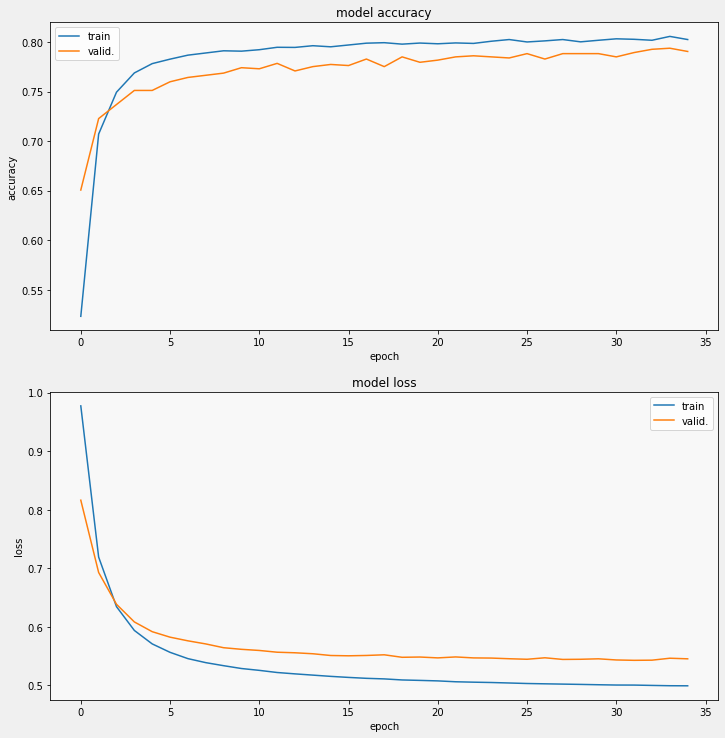

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5341 - accuracy: 0.7870 - 229ms/epoch - 57ms/step


loss: 0.534
accuracy: 0.787


We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 124ms/step


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background


We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/3
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json)